## Load Land Registry Data

In [1]:
import polars as pl
from pathlib import Path


def clean_land_registry(csv_path: Path | str) -> pl.LazyFrame:
    """
    Takes the *exact* CSV format you showed and returns a clean LazyFrame.
    """
    return (
        pl.scan_csv(
            csv_path,
            try_parse_dates=False,  # We'll parse manually
            quote_char='"',
            infer_schema_length=0,
        )
        .with_columns(
            [
                # 1. Parse price (remove commas if any, cast to Int64)
                pl.col("price_paid").str.replace_all(",", "").cast(pl.Int64),
                # 2. Parse deed_date → Date
                pl.col("deed_date").str.strptime(
                    pl.Date, format="%Y-%m-%d", strict=True
                ),
                # 3. Clean strings
                pl.col("postcode").str.strip_chars(),
                pl.col("town").str.strip_chars().str.to_uppercase(),
                pl.col("district").str.strip_chars().str.to_uppercase(),
                # pl.col("county").str.strip_chars().str.to_uppercase(),
                # 4. England-only filter (exclude Wales, Scotland, NI)
                pl.col("county")
                .str.contains("WALES|SCOTLAND|NORTHERN IRELAND")
                .not_()
                .over(pl.lit(1)),  # dummy window to create boolean column
            ]
        )
        .filter(pl.col("county"))  # drop the boolean column
        .with_columns(
            [
                # 5. Partition columns
                pl.col("deed_date").dt.year().alias("year"),
                pl.col("deed_date").dt.month().alias("month"),
            ]
        )
        .select(
            [
                "unique_id",
                "price_paid",
                "deed_date",
                "year",
                "month",
                "postcode",
                "property_type",
                "new_build",
                "estate_type",
                "saon",
                "paon",
                "street",
                "locality",
                "town",
                "district",
                "county",
                "transaction_category",
            ]
        )
    )


DATA_DIR = Path("../data/raw_land_registry")

lf = clean_land_registry(f"{DATA_DIR}/TA11.csv")
display(lf.collect().head(2))

unique_id,price_paid,deed_date,year,month,postcode,property_type,new_build,estate_type,saon,paon,street,locality,town,district,county,transaction_category
str,i64,date,i32,i8,str,str,str,str,str,str,str,str,str,str,bool,str
"""F7473CFF-4F88-4FC1-B913-4B900C…",480000,2011-05-16,2011,5,"""TA11 6AA""","""D""","""N""","""F""","""""","""HIGHER HURCOT HOUSE""","""""","""HURCOT""","""SOMERTON""","""SOUTH SOMERSET""",true,"""A"""
"""2333637D-2FAA-4129-9E11-002A9B…",345000,2015-01-30,2015,1,"""TA11 6AA""","""T""","""N""","""F""","""CALF BARN""","""HIGHER HURCOTT FARM""","""""","""HURCOT""","""SOMERTON""","""SOUTH SOMERSET""",true,"""A"""


## Open Database Connection

In [2]:
import duckdb


def open_database_connection():
    con = duckdb.connect("../data/house_prices.db")
    con.execute("INSTALL vortex; LOAD vortex;")
    return con

## Write to Vortex

In [3]:
con = open_database_connection()

# Register the lazy Polars frame
con.register("ppd_lf", lf)

# Write the polars dataframe to a vortex file
OUT_DIR = Path("../data/vortex")
OUT_DIR.mkdir(exist_ok=True)

# # Write partitioned Vortex dataset
con.execute(f"""
    COPY (
        SELECT * FROM ppd_lf
        ORDER BY deed_date
    )
    TO '{OUT_DIR / "house_prices.vortex"}'
    (FORMAT VORTEX, ROW_GROUP_SIZE 500_000, COMPRESSION ZSTD)
""")

print(f"Vortex dataset written to {OUT_DIR}")

Vortex dataset written to ../data/vortex


## Read from Database

In [4]:
con = open_database_connection()

# Example: Average price per year up to 2023
result = con.execute("""
    SELECT 
        year,
        AVG(price_paid)::INT64 AS avg_price,
        COUNT(*) AS sales_count
    FROM read_vortex('../data/vortex/*.vortex')
    WHERE deed_date < DATE '2024-01-01'
    GROUP BY year
    ORDER BY year
""").df()

print(result.head())

   year  avg_price  sales_count
0  1995      76110          144
1  1996      84834          167
2  1997      83361          195
3  1998      94430          217
4  1999     122966          204


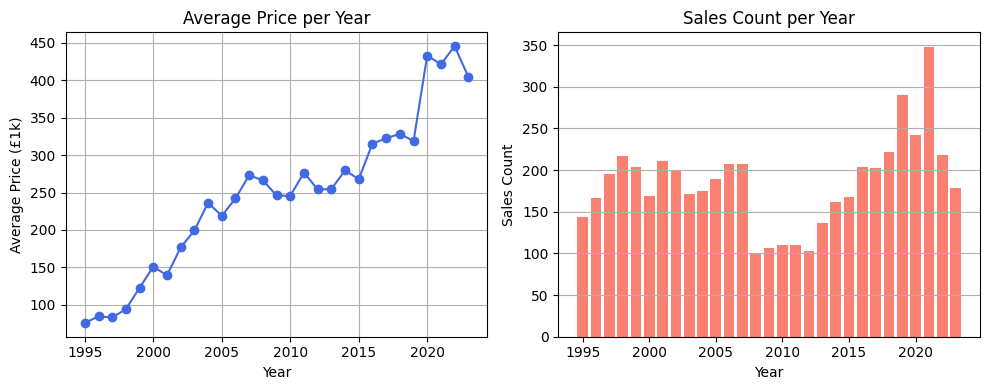

In [5]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(10, 4))

# Plot average price per year
axs[0].plot(result["year"], result["avg_price"] / 1000, marker="o", color="royalblue")
axs[0].set_title("Average Price per Year")
axs[0].set_xlabel("Year")
axs[0].set_ylabel("Average Price (£1k)")
axs[0].grid(True)

# Plot sales count per year
axs[1].bar(result["year"], result["sales_count"], color="salmon")
axs[1].set_title("Sales Count per Year")
axs[1].set_xlabel("Year")
axs[1].set_ylabel("Sales Count")
axs[1].grid(axis="y")

plt.tight_layout()
plt.show()